In [1]:
from utils_activations import replace_blocks_with_activation_vector, access_activations_forward_hook_gan, ForwardHookSetChannelsToValue

from core import load_gan

import torch
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
import torchvision

# replace with your local path to the stylegan2 repo
sys.path.append('/home/rherdt/git/stylegan2/stylegan2-ada-pytorch/')



def get_sample_images(G, activation_vector, layer, batch_size=8, block_sizes=[1, 2, 3, 4, 7]):
    imgs_block = [[] for _ in range(len(block_sizes))]


    activation_vector = torch.stack([activation_vector for _ in range(batch_size)])


    with torch.no_grad():
        label = torch.zeros([batch_size, G.c_dim], device="cuda")
        z = torch.from_numpy(np.random.RandomState(random.randint(0, 100000000)).randn(batch_size, G.z_dim)).to("cuda")
        activation, img_original = access_activations_forward_hook_gan(z, label, G, layer)
        img_original = img_original*0.5+0.5

        for idx_block, block_size in enumerate(block_sizes):
            replaced_activation = replace_blocks_with_activation_vector(activation, activation_vector, block_size=block_size)

            hook = ForwardHookSetChannelsToValue(forward_hook_point=layer,
                                            value_to_set_to=replaced_activation).set_hook()
            img_blocks = G(z, label, truncation_psi=1, noise_mode="const")*0.5+0.5
            img_blocks = img_blocks.cpu()

            imgs_block[idx_block].append(img_blocks)
            hook.remove()

        replaced_activation = torch.ones_like(activation) * activation_vector.unsqueeze(dim=-1).unsqueeze(dim=-1)
        hook = ForwardHookSetChannelsToValue(forward_hook_point=layer,
                                        value_to_set_to=replaced_activation).set_hook()
        img_full = G(z, label, truncation_psi=1, noise_mode="const")*0.5+0.5
        img_full = img_full.cpu()
        hook.remove()

    return imgs_block, img_full, img_original



/home/rherdt/anaconda3/envs/pytorch_cu11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

G = load_gan()

layer = G.synthesis.b32.conv1
background = 'original'
block_sizes = [1, 2, 3, 4, 7]
batch_size = 8


Example for a non-tileable feature (eye). Using a block size of 2 (third image from top below) gives realistic results. Larger block sizes detoriate the result. The top row shows the original image, the next five rows show the result for a block size of 1, 2, 3, 4, 7 and the last row shows the result when fully replicating the activation vector spatially.

We can see that for larger block sizes, the feature is stretching instead of tiling (i.e. we get one giant structure instead of having the eye repeat itself)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


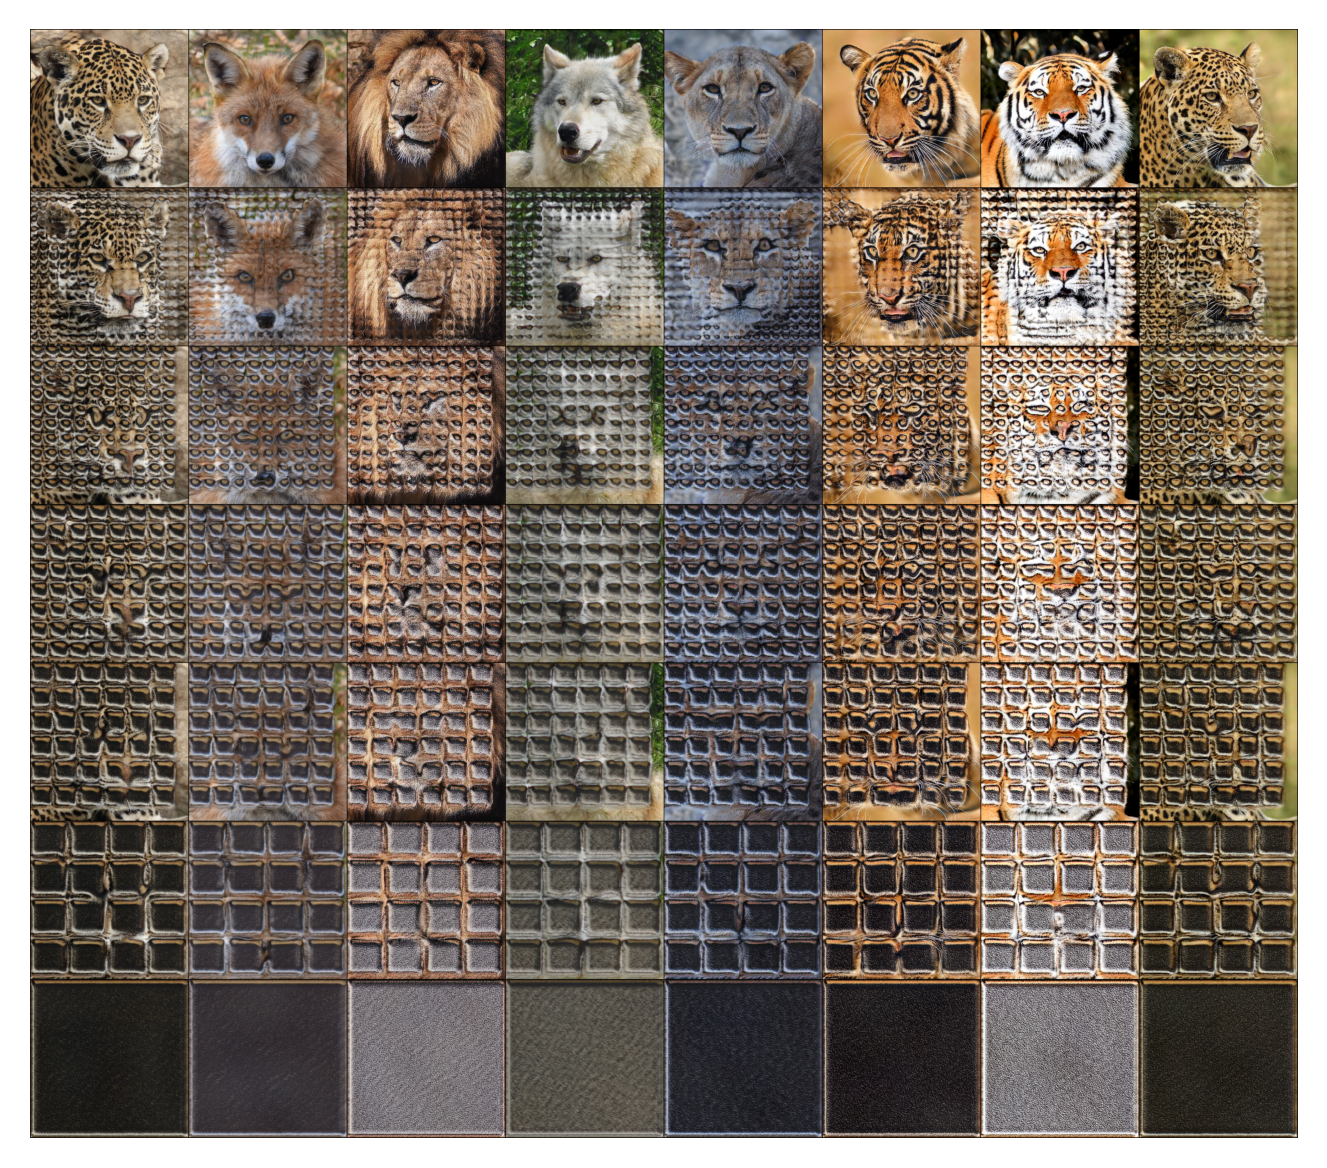

In [3]:
activation_vector = torch.load("example_vectors/activation_vector.pt")

imgs_block, img_full, img_original =  get_sample_images(G, activation_vector, layer, batch_size=8, block_sizes=[1, 2, 3, 4, 7])


imgs_block = torch.cat([img_original] + [img[0] for img in imgs_block] + [img_full], dim=0)
imgs_grid = torchvision.utils.make_grid(imgs_block)
imgs_grid = torch.permute(imgs_grid, (1, 2, 0))
fig = plt.figure(dpi=300)
plt.axis('off')
plt.imshow(imgs_grid)


Below is an example for a tileable feature (dotted fur). Here we can see that for larger block sizes the feature tiles, instead of stretching. Even though we are inserting the same activation vector into each of the 8 images, we get slightly different results. That is because we do not override the style vectors that come into the later layers.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


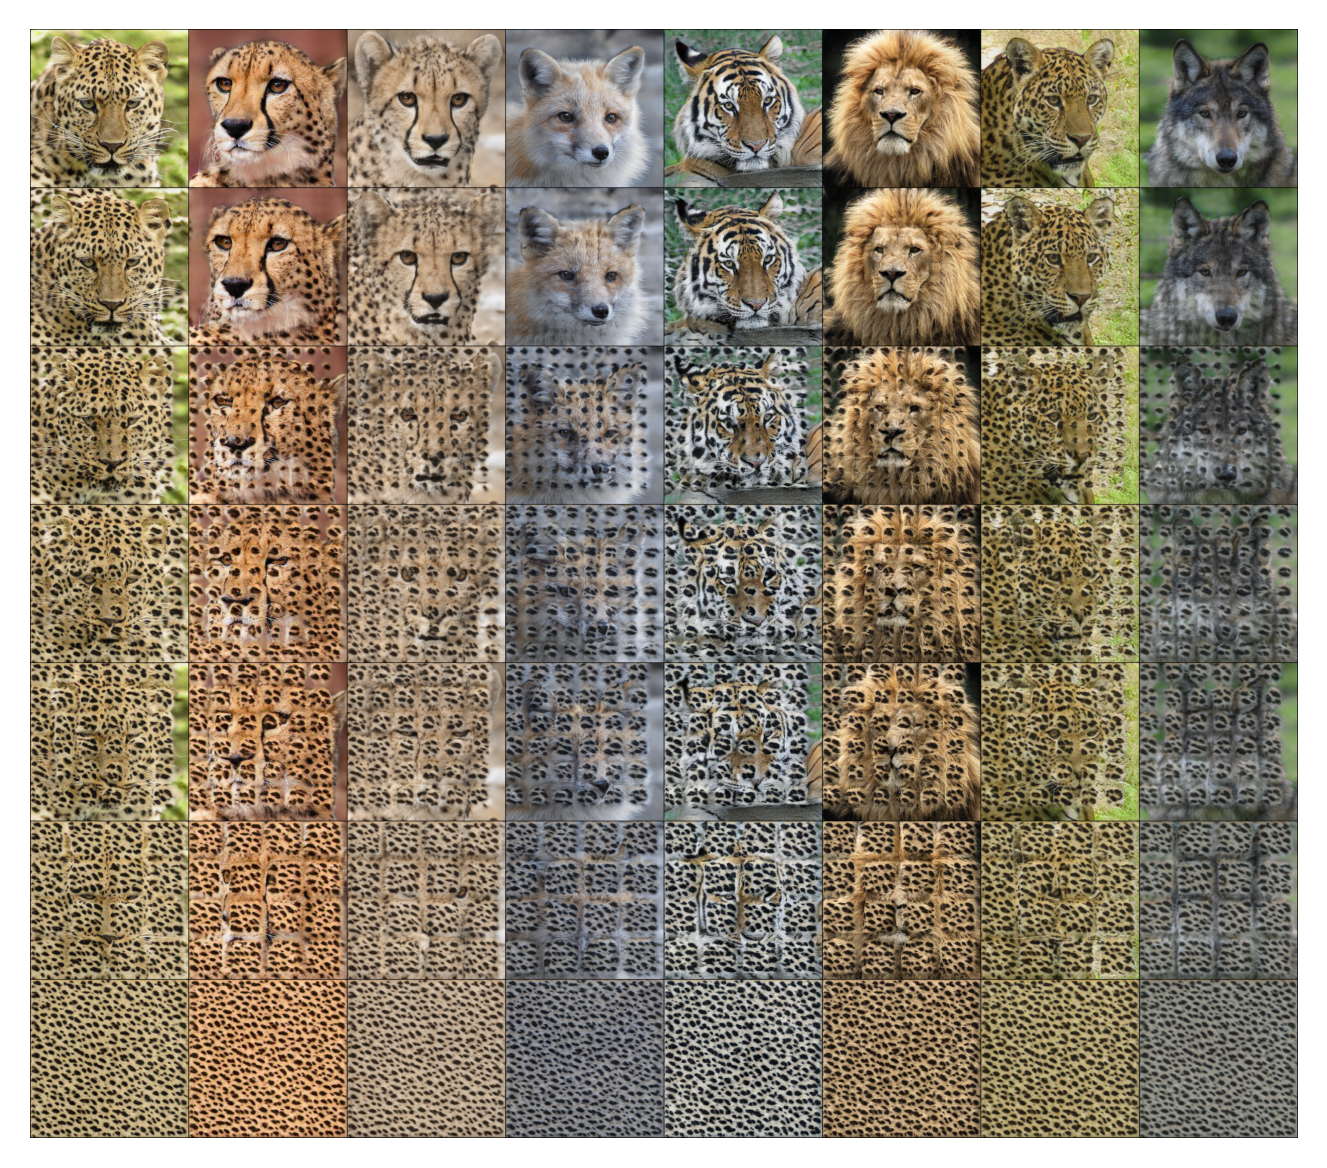

In [4]:
activation_vector = torch.load("example_vectors/activation_vector_tileable.pt")

imgs_block, img_full, img_original =  get_sample_images(G, activation_vector, layer, batch_size=8, block_sizes=[1, 2, 3, 4, 7])


imgs_block = torch.cat([img_original] + [img[0] for img in imgs_block] + [img_full], dim=0)
imgs_grid = torchvision.utils.make_grid(imgs_block)
imgs_grid = torch.permute(imgs_grid, (1, 2, 0))
fig = plt.figure(dpi=300)
plt.axis('off')
plt.imshow(imgs_grid)
